# Generic pipeline for segmentation tests

This notebook demonstrates how a pretrained model can be used to perform semantic segmentation on a set of images and compute some statistics on the identified objects. The model used below is the pretrained [`Mask2FormerForUniversalSegmentation`](https://huggingface.co/docs/transformers/en/model_doc/mask2former) model from Huggingface, which is an implementation of the [`Mask2Former`](https://arxiv.org/abs/2112.01527) model from FAIR.

In [1]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
import numpy as np

# --------------------------------------
from rich import print as pp

# --------------------------------------
from streetscapes import conf
from streetscapes.models import MaskFormerVistasPanoptic

## Load a segmentation model

In this example, we instruct the model that all instances of `sky` and `water` should be treated as a single instance.

In [2]:
mfp = MaskFormerVistasPanoptic(labels_to_fuse={"sky", "water"})

Select a few images at random.

<span style="color:red;">Note</span>: please make sure that you download some images first (cf. `download_city_images.ipynb`).

In [3]:
image_dir = conf.OUTPUT_DIR / "images"
images = list(np.random.choice(list(image_dir.glob("*.jpeg")), 2, replace=False))
[image.name for image in images]

['579902242993375.jpeg', '757814401546682.jpeg']

Choose one of those as a test image.

In [4]:
test_image = images[0].name

## Segment the images

In [5]:
segmentations = mfp.segment(images)

Streetscapes | 2024-12-06@15:46:11 | Segmenting images...


 50%|█████     | 1/2 [00:08<00:08,  8.35s/it]


Show the segmentation result for our test image.

In [6]:
segmentations[test_image]['segmentation']

tensor([[ 4,  4,  4,  ...,  4,  4,  4],
        [ 4,  4,  4,  ...,  4,  4,  4],
        [ 4,  4,  4,  ...,  4,  4,  4],
        ...,
        [21, 21, 21,  ...,  0,  0,  0],
        [21, 21, 21,  ...,  0,  0,  0],
        [21, 21, 21,  ...,  0,  0,  0]], dtype=torch.int32)

## Compute the statistics

The result is a dictionary of statistics for each segment of each category type.

In [7]:
stats = mfp.compute_statistics(images, segmentations)

Streetscapes | 2024-12-06@15:46:19 | Computing statistics...


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Show a subset of the statistics

In [8]:
pp(stats[test_image]['building'])

[
    {
        'colour': {'median': [82, 88, 95], 'mode': [18, 18, 170], 'mean': [100, 102, 104], 'sd': [69, 68, 60]},
        'area': 0.35587724049886066
    }
]

### Visualise the the segmentation results

Select a few categories that we might be interested in.

In [9]:
categories = {"sky", "building", "road", "vegetation", "water", "sidewalk", "person", "car", "bicyclist"}

Display the segmentation results.

Streetscapes | 2024-12-06@15:46:21 | Segmenting images...


 50%|█████     | 1/2 [00:01<00:01,  1.01s/it]


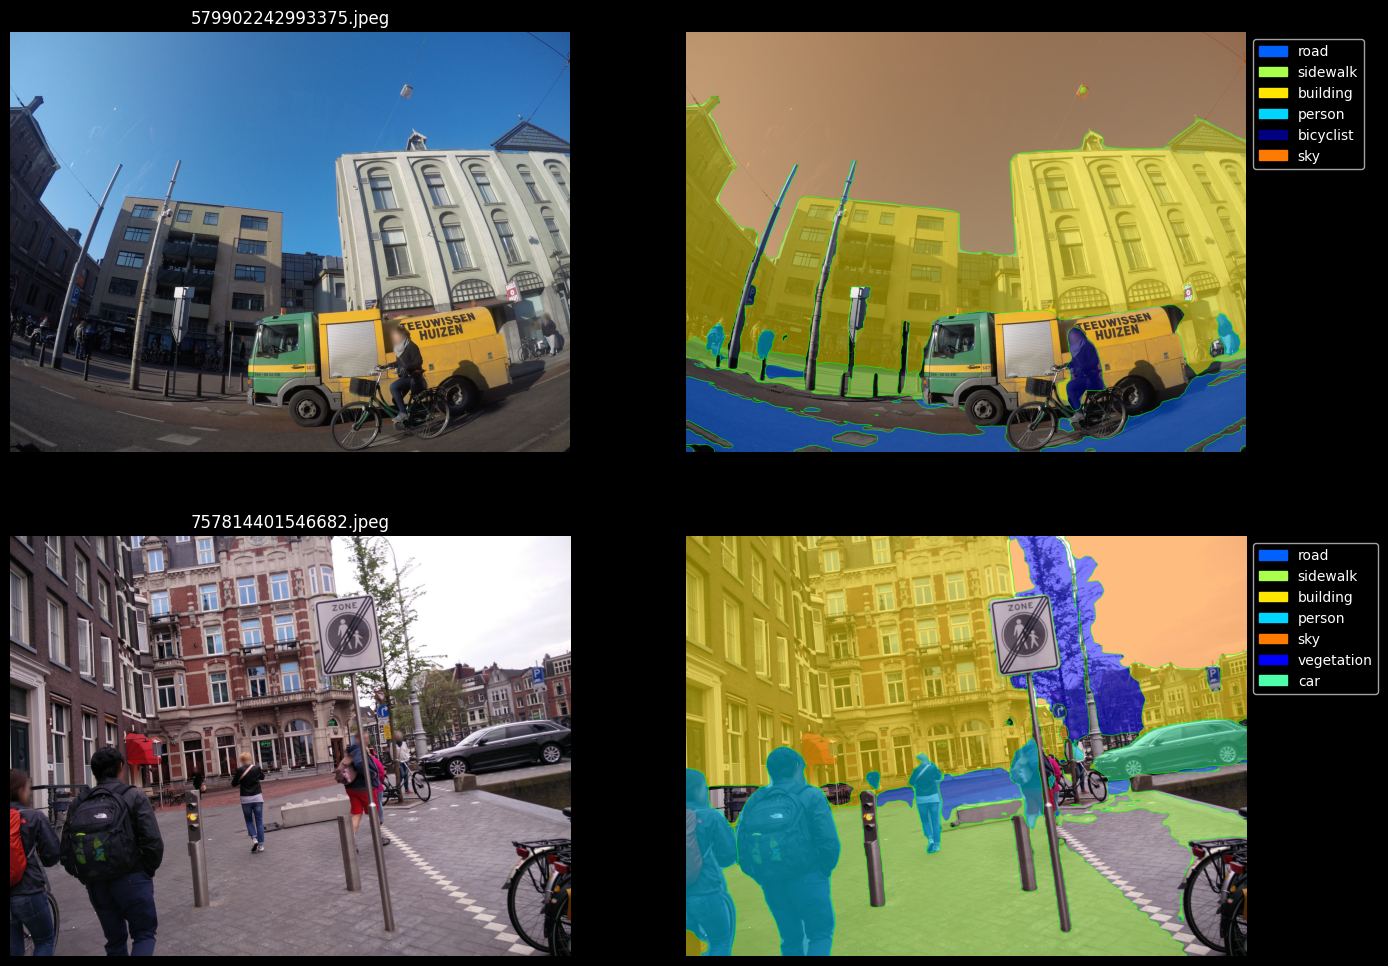

In [10]:
fig, ax, image_stats = mfp.visualise_segmentation(images, categories, stats=stats)

Show a subset of the statistics for one of the categories that we are interested in.

In [11]:
pp(image_stats[test_image]['building'])

[
    {
        'colour': {'median': [82, 88, 95], 'mode': [18, 18, 170], 'mean': [100, 102, 104], 'sd': [69, 68, 60]},
        'area': 0.35587724049886066
    }
]

## Process images from a subset

The segmentation model also provides a convenience method to process all the images in a subset of the `streetscapes` dataset.

Load a subset file.

In [12]:
amsterdam_side = conf.OUTPUT_DIR / "amsterdam_side.csv"

Select a file to save the statistics to.

In [13]:
out_file_path = amsterdam_side.with_name(f"{amsterdam_side.stem}-stats.parquet")

Process all images in the dataset and save the statistics to a Parquet file in one go.

In [14]:
(ds_images, ds_segmented, ds_stats) = mfp.segment_from_dataset(amsterdam_side, sample=5, out_file_path=out_file_path)

Streetscapes | 2024-12-06@15:46:34 | Segmenting images...


 20%|██        | 1/5 [00:25<01:42, 25.72s/it]

Streetscapes | 2024-12-06@15:47:00 | Computing statistics...



100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


The statistics can be loaded back into a dictionary format.

In [15]:
loaded_stats = mfp.load_stats(out_file_path)

Pick an image file and check that the computed statistics and the loaded statistics are identical

In [16]:
test_image = list(ds_images.keys())[0]

A sample item from the computed statistics

In [17]:
pp(ds_stats[test_image]['building'])

[
    {
        'colour': {'median': [54, 54, 53], 'mode': [83, 87, 89], 'mean': [56, 57, 56], 'sd': [35, 36, 36]},
        'area': 0.1481304168701172
    }
]

The same item from the loaded statistics

In [18]:
pp(loaded_stats[test_image]["building"])

[
    {
        'colour': {'median': [54, 54, 53], 'mode': [83, 87, 89], 'mean': [56, 57, 56], 'sd': [35, 36, 36]},
        'area': 0.1481304168701172
    }
]